In [5]:
import secret
import spotipy

from spotipy.oauth2 import SpotifyClientCredentials
cid = secret.client_id
secret = secret.client_secret
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [6]:
import pandas as pd

df_data = pd.read_json("one_year_streaming_history0.json")
df_data['endTime'] = pd.to_datetime(df_data['endTime']) 
df_data.head()

,endTime,artistName,trackName,msPlayed
0,2019-01-05 05:32:00,Tonight Alive,World Away,0
1,2019-01-05 05:36:00,Eminem,Greatest,226937
2,2019-01-05 05:40:00,Elephante,Sirens,249411
3,2019-01-05 05:45:00,Mike Williams,Bambini,2972
4,2019-01-05 05:45:00,Panic! At The Disco,High Hopes,190946


In [7]:
df_by_month = df_data.groupby([df_data['endTime'].dt.month, df_data['artistName'], df_data['trackName']]).sum().reset_index()
df_by_month.rename(columns={'endTime': 'month'}, inplace=True)
df_by_month

,month,artistName,trackName,msPlayed
0,1,12th Planet,Send It,205394
1,1,88GLAM,Kyrie,42992
2,1,ARTY,Rain,2786
3,1,Alec Benjamin,Let Me Down Slowly,678654
4,1,Apashe,Replicants - Kompany Remix,2003163
...,...,...,...,...
1599,12,Thomas Rhett,Craving You,223626
1600,12,Westlife,When You're Looking Like That - Single Remix,12306
1601,12,YBN Cordae,RNP (feat. Anderson .Paak),870076
1602,12,YUNGBLUD,11 Minutes (with Halsey feat. Travis Barker),192068


In [8]:
songs_liked = df_by_month.loc[df_by_month['msPlayed'] > (180000 * 5)].reset_index(drop=True)
songs_liked

,month,artistName,trackName,msPlayed
0,1,Apashe,Replicants - Kompany Remix,2003163
1,1,Ariana Grande,Be My Baby,1953477
2,1,Ariana Grande,Break Free,1504802
3,1,Ariana Grande,God is a woman,1975460
4,1,Ariana Grande,Greedy,1669257
...,...,...,...,...
347,12,Dan + Shay,Stop Drop + Roll,1183116
348,12,Dan + Shay,What Keeps You Up At Night,1034786
349,12,Kyan,How Dare You Make Me Love You,1047865
350,12,The Chainsmokers,Push My Luck,1106060


In [9]:
import numpy as np
songs_liked['uri'] = ""
songs_liked['popularity'] = 0
songs_liked['songLengthMs'] = 0
songs_liked['timesPlayed'] = 0


for idx, row in songs_liked.iterrows():
    results = sp.search(q='artist:{} track:{}'.format(
        songs_liked['artistName'][idx].lower(),
        songs_liked['trackName'][idx][:8].lower(), type='track'))

    try:
        uri = results['tracks']['items'][0]['uri'].split(':')[2]
        popularity = results['tracks']['items'][0]['popularity']
        song_length = results['tracks']['items'][0]['duration_ms']
        times_played = round(songs_liked['msPlayed'][idx] / song_length, 2)
    except:
        IndexError

    songs_liked.at[idx, 'uri'] = uri
    songs_liked.at[idx, 'popularity'] = popularity
    songs_liked.at[idx, 'songLengthMs'] = song_length
    songs_liked.at[idx, 'timesPlayed'] = times_played

songs_liked

,month,artistName,trackName,msPlayed,uri,popularity,songLengthMs,timesPlayed
0,1,Apashe,Replicants - Kompany Remix,2003163,4xpdXptEjV9LoHUOthvIxH,23,230400,8
1,1,Ariana Grande,Be My Baby,1953477,0fonaf88IEDQM309zmU80L,58,217053,9
2,1,Ariana Grande,Break Free,1504802,12KUFSHFgT0XCoiSlvdQi4,73,214840,7
3,1,Ariana Grande,God is a woman,1975460,5OCJzvD7sykQEKHH7qAC3C,79,197546,10
4,1,Ariana Grande,Greedy,1669257,2tpIAmAq9orm1Owh5pja1w,66,214906,7
...,...,...,...,...,...,...,...,...
347,12,Dan + Shay,Stop Drop + Roll,1183116,2LNoMwodbEfYFaXY2loO5V,48,197186,6
348,12,Dan + Shay,What Keeps You Up At Night,1034786,3rHrG1sHYd7h2yWKnxRk56,61,201946,5
349,12,Kyan,How Dare You Make Me Love You,1047865,0tI6lHDw4q10J676IZmx25,36,209573,5
350,12,The Chainsmokers,Push My Luck,1106060,4h8Pmw3RELdsanPjssyJoB,74,181853,6


In [10]:
def get_features_of_songs():
    i = 0
    info_list = []
    for idx, row in songs_liked.iterrows():
        result = sp.audio_features(row['uri'])
        result = result[0]

        info_list.append([
            result['danceability'], 
            result['energy'],
            result['key'],
            result['loudness'],
            result['mode'],
            result['speechiness'],
            result['acousticness'],
            result['liveness'],
            result['valence'],
            result['tempo']])

        song_data = pd.DataFrame(info_list)
        song_data.columns = [
            'danceability',
            'energy',
            'key',
            'loudness',
            'mode',
            'speechiness',
            'acousticness',
            'liveness',
            'valence',
            'tempo']

    return(song_data)

In [11]:
song_data = get_features_of_songs()
song_data

retrying after...1secs


,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo
0,0.465,0.9890,0,-0.660,1,0.1980,0.01680,0.1320,0.127,149.788
1,0.622,0.5860,3,-6.241,0,0.0356,0.07350,0.0803,0.434,145.080
2,0.687,0.7020,7,-5.324,0,0.0455,0.00640,0.2040,0.284,129.956
3,0.602,0.6580,1,-5.934,1,0.0558,0.02330,0.2370,0.268,145.031
4,0.620,0.7050,1,-5.335,1,0.0989,0.03230,0.0920,0.844,109.974
...,...,...,...,...,...,...,...,...,...,...
347,0.489,0.7890,1,-4.995,1,0.0323,0.16800,0.1430,0.764,175.914
348,0.588,0.5330,7,-6.136,0,0.0314,0.42500,0.2360,0.534,137.076
349,0.330,0.0882,4,-12.949,1,0.0349,0.92400,0.1090,0.200,114.989
350,0.563,0.6450,2,-6.422,1,0.0428,0.29300,0.2020,0.523,89.976


In [12]:
songs_liked_with_data = pd.concat([songs_liked, song_data], axis=1)
songs_liked_with_data

,month,artistName,trackName,msPlayed,uri,popularity,songLengthMs,timesPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo
0,1,Apashe,Replicants - Kompany Remix,2003163,4xpdXptEjV9LoHUOthvIxH,23,230400,8,0.465,0.9890,0,-0.660,1,0.1980,0.01680,0.1320,0.127,149.788
1,1,Ariana Grande,Be My Baby,1953477,0fonaf88IEDQM309zmU80L,58,217053,9,0.622,0.5860,3,-6.241,0,0.0356,0.07350,0.0803,0.434,145.080
2,1,Ariana Grande,Break Free,1504802,12KUFSHFgT0XCoiSlvdQi4,73,214840,7,0.687,0.7020,7,-5.324,0,0.0455,0.00640,0.2040,0.284,129.956
3,1,Ariana Grande,God is a woman,1975460,5OCJzvD7sykQEKHH7qAC3C,79,197546,10,0.602,0.6580,1,-5.934,1,0.0558,0.02330,0.2370,0.268,145.031
4,1,Ariana Grande,Greedy,1669257,2tpIAmAq9orm1Owh5pja1w,66,214906,7,0.620,0.7050,1,-5.335,1,0.0989,0.03230,0.0920,0.844,109.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,12,Dan + Shay,Stop Drop + Roll,1183116,2LNoMwodbEfYFaXY2loO5V,48,197186,6,0.489,0.7890,1,-4.995,1,0.0323,0.16800,0.1430,0.764,175.914
348,12,Dan + Shay,What Keeps You Up At Night,1034786,3rHrG1sHYd7h2yWKnxRk56,61,201946,5,0.588,0.5330,7,-6.136,0,0.0314,0.42500,0.2360,0.534,137.076
349,12,Kyan,How Dare You Make Me Love You,1047865,0tI6lHDw4q10J676IZmx25,36,209573,5,0.330,0.0882,4,-12.949,1,0.0349,0.92400,0.1090,0.200,114.989
350,12,The Chainsmokers,Push My Luck,1106060,4h8Pmw3RELdsanPjssyJoB,74,181853,6,0.563,0.6450,2,-6.422,1,0.0428,0.29300,0.2020,0.523,89.976


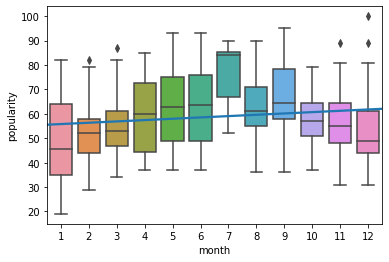

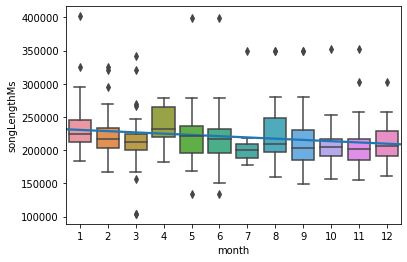

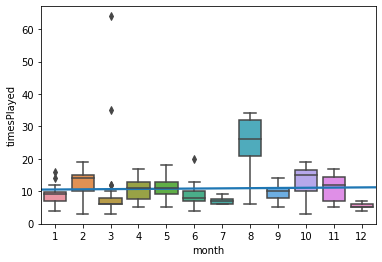

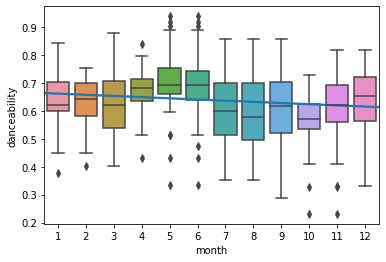

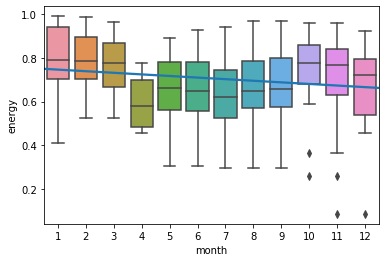

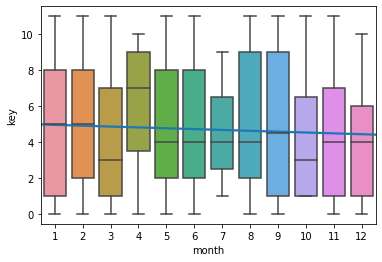

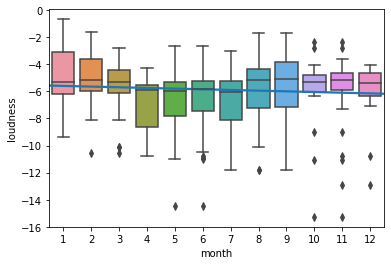

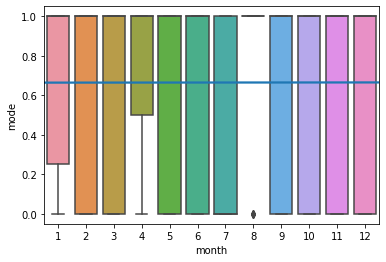

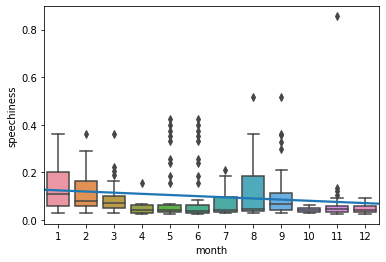

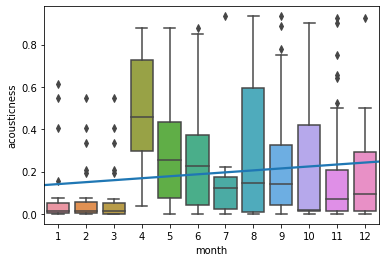

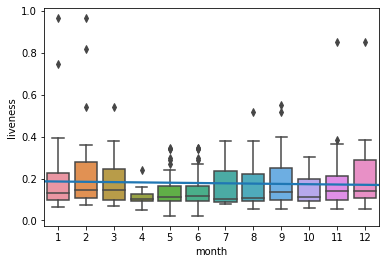

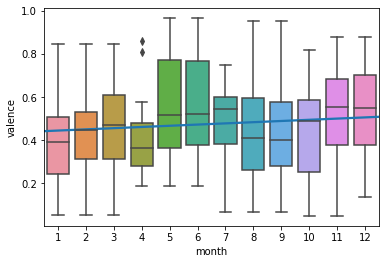

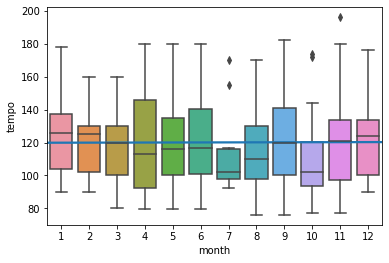

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

of_interest=['popularity', 'songLengthMs', 'timesPlayed', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']

graphs = [None] * len(of_interest)

for i in range(len(of_interest)):
    plt.figure()
    graph1 = sns.boxplot(data=songs_liked_with_data, x='month', y=of_interest[i])
    graph2 = sns.regplot(data=songs_liked_with_data, x='month', y=of_interest[i], ci=None, scatter=False)
 
    graphs[i] = graph1
    plt.show()

In [ ]:
graphs[4].figure

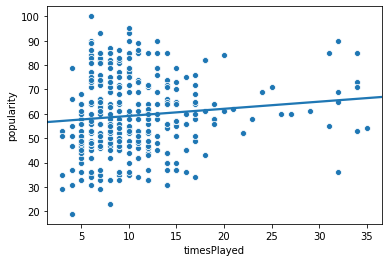

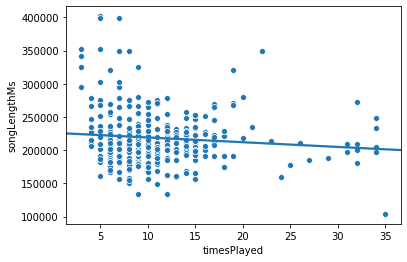

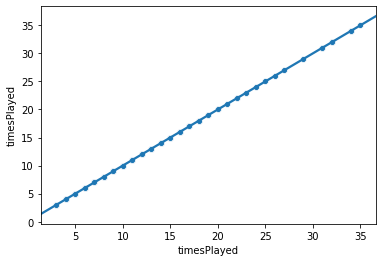

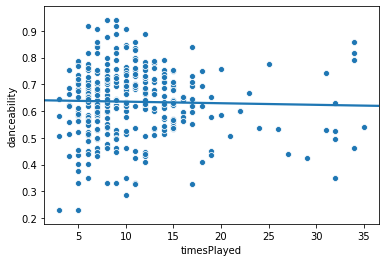

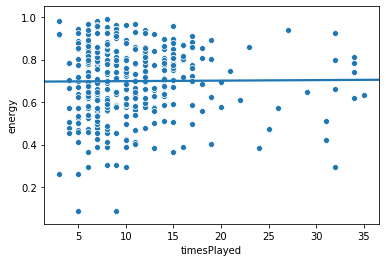

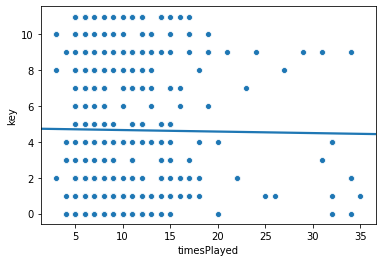

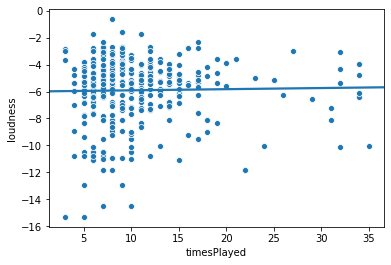

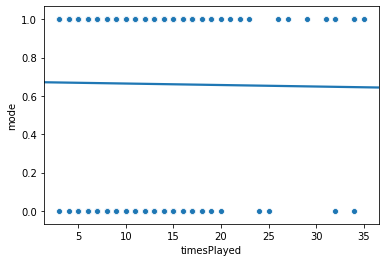

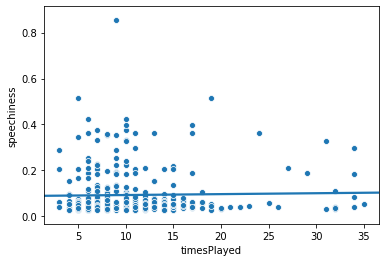

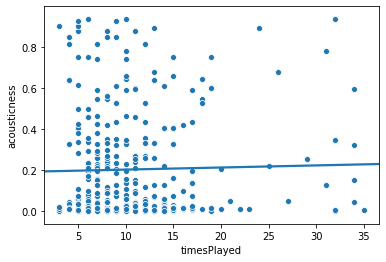

In [23]:
without_outlier = songs_liked_with_data[songs_liked_with_data['timesPlayed'] < 58]
for i in range(len(of_interest[3:])):
    plt.figure()
    sns.scatterplot(data=without_outlier, x='timesPlayed', y=of_interest[i])
    sns.regplot(data=without_outlier, x='timesPlayed', y=of_interest[i], ci=None, scatter=False)

plt.show()

In [26]:
key_vs_pop = songs_liked_with_data[['key', 'popularity']].groupby('key').sum()
key_vs_pop

,popularity
key,
0,1901
1,3439
2,2937
3,1072
4,1823
5,1229
6,865
7,1610
8,1402


In [29]:
songs_in_c_sharp = songs_liked_with_data[songs_liked_with_data['key'] == 2]
songs_in_c_sharp

,month,artistName,trackName,msPlayed,uri,popularity,songLengthMs,timesPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo
7,1,Black Tiger Sex Machine,Death feat. Lektrique,3215029,3sCtI5oAoXGghMpUkOKo6e,35,325384,9,0.644,0.914,2,-3.634,1,0.2900,0.010400,0.0981,0.1640,130.045
10,1,Black Tiger Sex Machine,Religion - Far Too Loud Remix,2237518,3h3nlfgeLsjWW5otfkXUWo,47,228996,9,0.622,0.957,2,-2.993,1,0.1040,0.000436,0.1260,0.4340,130.035
12,1,Black Tiger Sex Machine,Zombie feat. Panther,3226166,6Ytdv9pEdBWdVfo1my1Ud8,45,200700,16,0.641,0.867,2,-2.811,1,0.0678,0.008680,0.0940,0.5200,99.994
32,2,Black Tiger Sex Machine,Death feat. Lektrique,1293705,3sCtI5oAoXGghMpUkOKo6e,35,325384,3,0.644,0.914,2,-3.634,1,0.2900,0.010400,0.0981,0.1640,130.045
36,2,Black Tiger Sex Machine,Zombie feat. Panther,3293366,6Ytdv9pEdBWdVfo1my1Ud8,45,200700,16,0.641,0.867,2,-2.811,1,0.0678,0.008680,0.0940,0.5200,99.994
47,2,ODESZA,Late Night,3344285,5Nu5Uyoauauy9LFePYL1Z3,64,228154,14,0.612,0.628,2,-6.754,1,0.0752,0.035800,0.1930,0.4340,125.043
57,2,flor,heart,3909230,6l9AVZVrvHw5u4nL3HL9N0,49,222825,17,0.644,0.884,2,-4.577,1,0.0389,0.009730,0.0727,0.4750,97.987
63,3,Black Tiger Sex Machine,Zombie feat. Panther,1379096,6Ytdv9pEdBWdVfo1my1Ud8,45,200700,6,0.641,0.867,2,-2.811,1,0.0678,0.008680,0.0940,0.5200,99.994
72,3,Gary Clark Jr.,Come Together,1355998,45HAjqRWiNv6mMPw4NvZrU,64,193714,7,0.447,0.788,2,-4.994,0,0.0464,0.002570,0.0744,0.5050,80.040
75,3,Ghost,Square Hammer,2289894,2XgTw2co6xv95TmKpMcL70,61,239293,9,0.530,0.903,2,-4.396,0,0.0483,0.000033,0.2590,0.7470,129.983
